## Imports

In [7]:
import scipy.io
import scipy.signal
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

import os 

import zipfile
import requests
import xlrd
import matplotlib
 
import seaborn as sns
import statistics as stats
from math import isclose

%matplotlib inline

## Nicole's imports

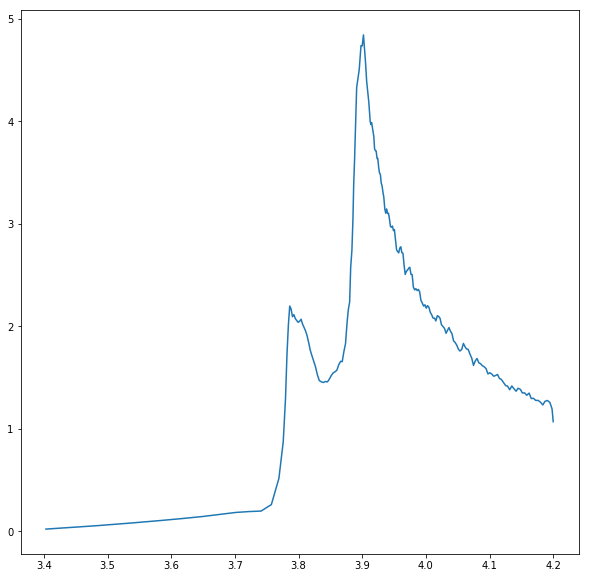

In [6]:
import chachifuncs_sepcd as ccf
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

#chachifuncs.load_sep_cycles('NLT_Test/NLT_TestSource/', 'NLT_Test/NLT_TestSepCycles/')
# I had to make this first directory (source) just as a small set of the data to test this code on, and then had to make a 
#directory for where I wanted my cycles to be stored in once they were seperated out. This code takes a while to run.
testdf = pd.read_excel('NLT_Test/Clean_Separated_Cycles/CS2_33_10_04_10-Cycle10Clean.xlsx')
#just picked a random one out of the separated out cycles

charge, discharge = ccf.sep_char_dis(testdf)

fig = plt.figure(figsize=(10, 10), facecolor='w', edgecolor='k')
myplot = plt.plot(charge['Voltage(V)'], charge['Smoothed_dQ/dV'])

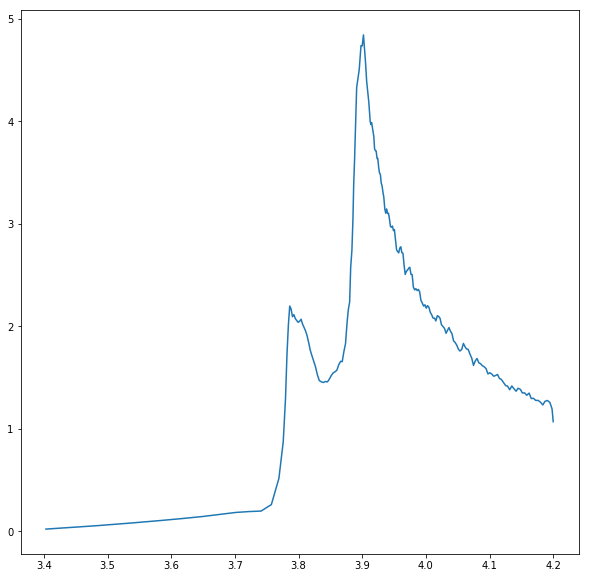

In [5]:
sigx_bot = pd.to_numeric(charge['Voltage(V)']).as_matrix()
sigy_bot = pd.to_numeric(charge['Smoothed_dQ/dV']).as_matrix()

fig = plt.figure(figsize=(10, 10), facecolor='w', edgecolor='k')
myplot = plt.plot(sigx_bot, sigy_bot)

## ML Prep stuff

In [3]:
import descriptors

charge_descript, discharge_descript, name = descriptors.imp_all('data/Clean_Separated_Cycles', 'CS2_33_10_04_10')
df = descriptors.pd_create(charge_descript, name, 'c')
descriptors.pd_update(df, charge_descript)

C:\Users\Theodore Cohen\Desktop\Direct\chachies\chachies\descriptors.py:57: RuntimeWarning: divide by zero encountered in double_scalars
  i = peakutils.indexes(sigy_smooth, thres=3/max(sigy_smooth), min_dist=9)
c:\python\lib\site-packages\peakutils\peak.py:37: RuntimeWarning: invalid value encountered in double_scalars
  thres = thres * (np.max(y) - np.min(y)) + np.min(y)


data/Clean_Separated_Cycles\CS2_33_10_04_10-Cycle1Clean.xlsx


,Name,ch_0,ch_1,ch_2,ch_3,ch_4,ch_5,ch_6,ch_7,ch_8,ch_9
0,CS2_33_10_04_10,6.245338e+05,-7.219103e+05,310278.247811,-58797.55871,3.659013,677.993940,0.037453,3.584335,391.216016,0.014332
1,CS2_33_10_04_10,1.169960e+06,-1.329735e+06,561028.227963,-104207.50166,3.670352,1749.767111,0.033049,3.589681,961.357581,0.010910


In [1]:
import chachifuncs_sepcd as ccf
ccf.get_all_data('NLT_Test/', 'NLT_TestSource/')

All data separated into cycles and saved in folder "data/Separated_Cycles". 
All cycles cleaned and saved in folder "data/Clean_Separated_Cycles".
All clean cycles recombined and saved in folder "data/Clean_Whole_Sets".


In [2]:
%%time
import descriptors
df = descriptors.ML_generate('NLT_Test/Clean_Separated_Cycles')
df.columns



NLT_Test/Clean_Separated_Cycles\CS2_33_10_04_10-Cycle23Clean.xlsx
NLT_Test/Clean_Separated_Cycles\CS2_33_10_04_10-Cycle23Clean.xlsx
Wall time: 7min 29s


In [7]:
writer = pd.ExcelWriter('CS2_33_10_04_10-12_23_10.xlsx')
df.to_excel(writer,'Sheet1')
writer.save()

In [1]:
import descriptors
descriptors.imp_all('NLT_test/Clean_Separated_Cycles', 'CS2_33_12_23')

KeyboardInterrupt: 

## Peak Utils Peak finder

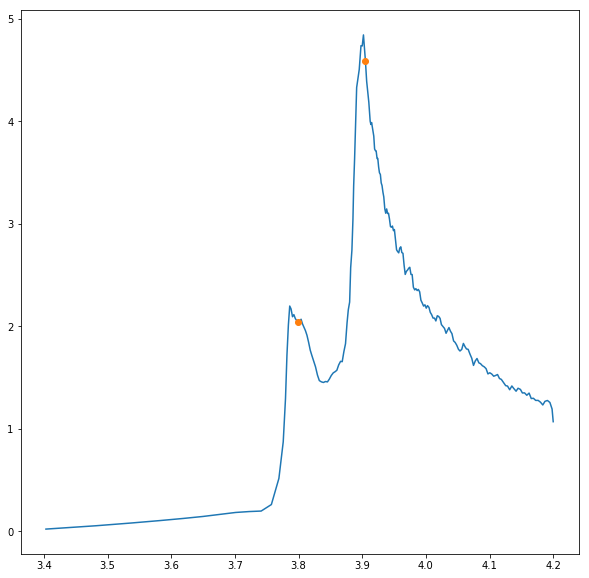

In [9]:

sigy_smooth = scipy.signal.savgol_filter(sigy_bot, 25, 3)
import peakutils
i = peakutils.indexes(sigy_smooth, thres=.3/max(sigy_bot), min_dist=9)
#i = scipy.signal.find_peaks_cwt(sigy, sigx*9)

fig = plt.figure(figsize=(10, 10), facecolor='w', edgecolor='k')
plt.plot(sigx_bot, sigy_bot)
plt.plot(sigx_bot[i], sigy_bot[i], 'o')

Function Version

In [36]:
import peakutils
import scipy.signal

def peak_finder(V_series, dQdV_series, cd):
    
    sigx, sigy = cd_dataframe(V_series, dQdV_series, cd)
    
    sigy_smooth = scipy.signal.savgol_filter(sigy, 25, 3)
        
    i = peakutils.indexes(sigy_smooth, thres=3/max(sigy_smooth), min_dist=9)
    return i

def cd_dataframe(V_series, dQdV_series, cd):
    """Classifies and flips differential capactity data.
        V_series = Pandas series of voltage data
        dQdV_series = Pandas series of differential capacity data
        cd = either 'c' for charge and 'd' for discharge."""
    
    sigx = pd.to_numeric(V_series).as_matrix()
    if cd == 'c':      
        sigy = -pd.to_numeric(dQdV_series).as_matrix()
    elif cd == 'd':
        sigy = pd.to_numeric(dQdV_series).as_matrix()
    
    return sigx, sigy
    

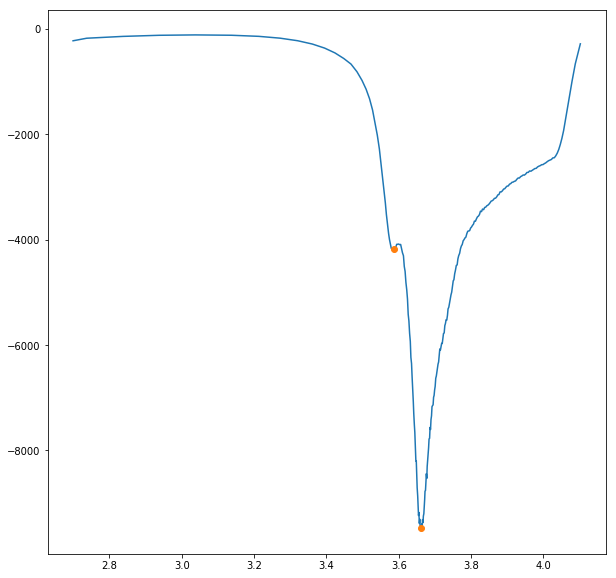

In [37]:
i = peak_finder(charge['Voltage(V)'], charge['Smoothed_dQ/dV'], 'c')

fig = plt.figure(figsize=(10, 10), facecolor='w', edgecolor='k')
myplot = plt.plot(charge['Voltage(V)'], charge['Smoothed_dQ/dV'])
myplot = plt.plot(charge.loc[i, 'Voltage(V)'], charge.loc[i, 'Smoothed_dQ/dV'], 'o')

## LMfit code

In [14]:
from lmfit import models

mod = models.PolynomialModel(4)
par = mod.guess(sigy_bot, x=sigx_bot)
#i = np.append(i, i+5)
print(i)


for index in i:
    pref = str(int(index))
    comb = 'a' + pref + '_'
    
    gaus_loop = models.PseudoVoigtModel(prefix=comb)
    par.update(gaus_loop.make_params())
    cent = 'center'
    sig = 'sigma'
    amp = 'amplitude'
    fract = 'fraction'
    
    par[comb+cent].set(sigx_bot[index], vary=False)
    par[comb+sig].set(0.01)
    par[comb+amp].set(.05, min=0)
    par[comb+fract].set(.5)

    mod = mod + gaus_loop

[22 64]


## LMfit function

In [29]:
from lmfit import models

def model_gen(V_series, dQdV_series, cd, i):
    """Develops initial model and parameters for battery data fitting.

V_series = Pandas series of voltage data
dQdV_series = Pandas series of differential capacity data
cd = either 'c' for charge and 'd' for discharge.

Output:
par = lmfit parameters object
mod = lmfit model object"""
    
    sigx_bot, sigy_bot = cd_dataframe(V_series, dQdV_series, cd)
    
    mod = models.PolynomialModel(4)
    par = mod.guess(sigy_bot, x=sigx_bot)
    #i = np.append(i, i+5)
    #print(i)

    for index in i:
        
        center, sigma, amplitude, fraction, comb = label_gen(index)
        
        gaus_loop = models.PseudoVoigtModel(prefix=comb)
        par.update(gaus_loop.make_params())

        par[center].set(sigx_bot[index], vary=False)
        par[sigma].set(0.001)
        par[amplitude].set(5, min=0)
        par[fraction].set(.5, min=0, max=1)

        mod = mod + gaus_loop
        
    return par, mod

def model_eval(V_series, dQdV_series, cd, par, mod):
    sigx_bot, sigy_bot = cd_dataframe(V_series, dQdV_series, cd)
    
    model = mod.fit(sigy_bot, par, x=sigx_bot)
    #print(model.fit_report(min_correl=0.5))

    fig = plt.figure(figsize=(10, 10), facecolor='w', edgecolor='k')
    plt.plot(sigx_bot, sigy_bot)
    #plt.plot(sigx_bot, model.init_fit, 'k--')
    plt.plot(sigx_bot, model.best_fit, 'r-')
    
    return model

def label_gen(index):
    """Generates label set for individual gaussian
index = index of peak location

output string format: 
'a' + index + "_" + parameters"""
    
    pref = str(int(index))
    comb = 'a' + pref + '_'
    
    cent = 'center'
    sig = 'sigma'
    amp = 'amplitude'
    fract = 'fraction'
    
    center = comb + cent
    sigma = comb + sig
    amplitude = comb + amp
    fraction = comb + fract
    
    return center, sigma, amplitude, fraction, comb
    

[ 21 160 205]
[[Model]]
    (((Model(polynomial) + Model(pvoigt, prefix='a21_')) + Model(pvoigt, prefix='a160_')) + Model(pvoigt, prefix='a205_'))
[[Fit Statistics]]
    # function evals   = 20606
    # data points      = 238
    # variables        = 14
    chi-square         = 505317050.683
    reduced chi-square = 2255879.691
    Akaike info crit   = 3495.285
    Bayesian info crit = 3543.897
[[Variables]]
    c0:               1.5145e+07 +/- 0        (0.00%) (init= 1.509032e+07)
    c1:              -1.7346e+07 +/- 0        (0.00%) (init=-1.733631e+07)
    c2:               7.3845e+06 +/- 0        (0.00%) (init= 7388906)
    c3:              -1.3857e+06 +/- 0        (0.00%) (init=-1385266)
    c4:               96784.7023 +/- 0        (0.00%) (init= 96460.89)
    a21_fraction:     1          +/- 0        (0.00%) (init= 0.5)
    a21_sigma:        0.26181188 +/- 0        (0.00%) (init= 0.001)
    a21_center:       4.004055 (fixed)
    a21_amplitude:    1864.94461 +/- 0        (0.00%) 

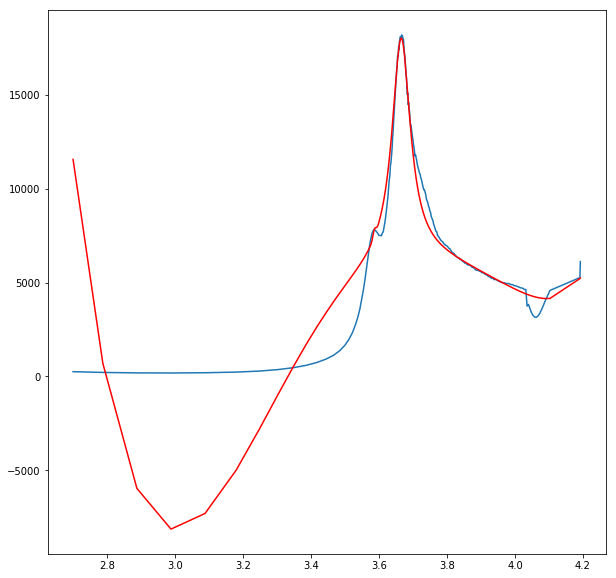

In [57]:
par, mod = model_gen(charge['Voltage(V)'], charge['Smoothed_dQ/dV'], 'c', i)

model = model_eval(charge['Voltage(V)'], charge['Smoothed_dQ/dV'], 'c', par, mod)

In [41]:
model.best_values

{'a160_amplitude': 1204.5866768625697,
 'a160_center': 3.665168762207031,
 'a160_fraction': 0.9999395740501419,
 'a160_sigma': 0.03271931592717259,
 'a205_amplitude': 4.396018661100393,
 'a205_center': 3.586440801620483,
 'a205_fraction': 1.0103029524088925e-13,
 'a205_sigma': 0.005223141124625519,
 'a21_amplitude': 1864.944618803519,
 'a21_center': 4.004055023193359,
 'a21_fraction': 0.999999999999958,
 'a21_sigma': 0.2618118855452114,
 'c0': 15144956.27369092,
 'c1': -17346234.574764214,
 'c2': 7384508.879733742,
 'c3': -1385730.6474814473,
 'c4': 96784.70232873314}

## Putting it all together

In [31]:
def descriptor_func(V_series,dQdV_series, cd):
    """Generates dictionary of descriptors

V_series = Pandas series of voltage data
dQdV_series = Pandas series of differential capacity data
cd = either 'c' for charge and 'd' for discharge."""
    sigx_bot, sigy_bot = cd_dataframe(V_series, dQdV_series, cd)
    
    i = peak_finder(V_series,dQdV_series, cd)
    
    par, mod = model_gen(V_series,dQdV_series, cd, i)

    model = model_eval(V_series,dQdV_series, cd, par, mod)
    
    sigx, sigy = cd_dataframe(V_series, dQdV_series, cd) 
    
    desc = {'peakLocation(V)': sigx[i], 'peakHeight(dQdV)': sigy[i]}
    
    FWHM = []
    for index in i:
        center, sigma, amplitude, fraction, comb = label_gen(index)
        FWHM.append(model.best_values[sigma])

    
    coefficients = []
    for k in np.arange(4):
        coef = 'c' + str(k)
        coefficients.append(model.best_values[coef])
        
    desc.update({'peakFWHM': FWHM, 'coefficients': coefficients})
    
    return desc
    
    

[ 21 160 205]
[[Model]]
    (((Model(polynomial) + Model(pvoigt, prefix='a21_')) + Model(pvoigt, prefix='a160_')) + Model(pvoigt, prefix='a205_'))
[[Fit Statistics]]
    # function evals   = 20606
    # data points      = 238
    # variables        = 14
    chi-square         = 505317050.683
    reduced chi-square = 2255879.691
    Akaike info crit   = 3495.285
    Bayesian info crit = 3543.897
[[Variables]]
    c0:               1.5145e+07 +/- 0        (0.00%) (init= 1.509032e+07)
    c1:              -1.7346e+07 +/- 0        (0.00%) (init=-1.733631e+07)
    c2:               7.3845e+06 +/- 0        (0.00%) (init= 7388906)
    c3:              -1.3857e+06 +/- 0        (0.00%) (init=-1385266)
    c4:               96784.7023 +/- 0        (0.00%) (init= 96460.89)
    a21_fraction:     1          +/- 0        (0.00%) (init= 0.5)
    a21_sigma:        0.26181188 +/- 0        (0.00%) (init= 0.001)
    a21_center:       4.004055 (fixed)
    a21_amplitude:    1864.94461 +/- 0        (0.00%) 

{'coefficients': [15144956.27369092,
  -17346234.574764214,
  7384508.879733742,
  -1385730.6474814473],
 'peakFWHM': [0.2618118855452114, 0.03271931592717259, 0.005223141124625519],
 'peakHeight(dQdV)': array([ 4818.08876597, 17977.98977003,  7819.18324064]),
 'peakLocation(V)': array([4.00405502, 3.66516876, 3.5864408 ])}

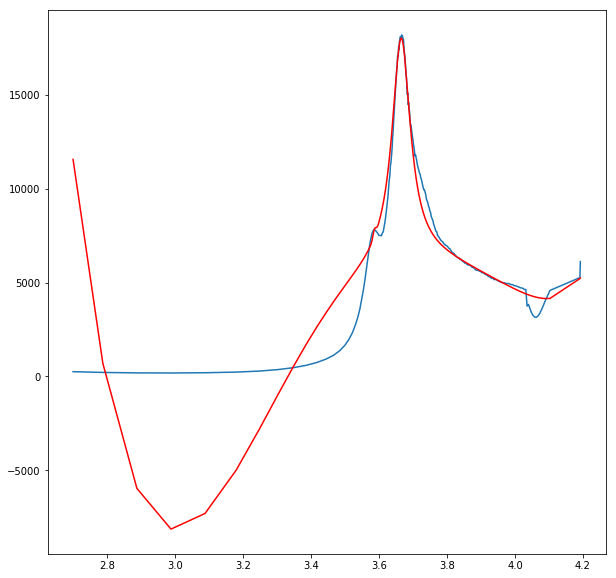

In [72]:
descriptor_func(charge['Voltage(V)'], charge['Smoothed_dQ/dV'], 'c')

In [70]:
i2 = np.array([i[-1] + 10])
for index in i2:
    pref = str(int(index))
    comb = 'a' + pref + '_'
    
    gaus_loop = models.GaussianModel(prefix=comb)
    par.update(gaus_loop.make_params())
    cent = 'center'
    sig = 'sigma'
    amp = 'amplitude'
    
    par[comb+cent].set(sigx_bot[index])
    par[comb+sig].set(0.01)
    par[comb+amp].set(500)

    mod = mod + gaus_loop

[[Model]]
    ((Model(polynomial) + Model(pvoigt, prefix='a22_')) + Model(pvoigt, prefix='a64_'))
[[Fit Statistics]]
    # function evals   = 1021
    # data points      = 193
    # variables        = 11
    chi-square         = 8.038
    reduced chi-square = 0.044
    Akaike info crit   = -591.448
    Bayesian info crit = -555.558
[[Variables]]
    c0:             -17364.2780 +/- 3.83e+03 (22.08%) (init= 48688.95)
    c1:              18630.8937 +/- 4.02e+03 (21.59%) (init=-50474.09)
    c2:             -7479.94472 +/- 1.58e+03 (21.12%) (init= 19569.17)
    c3:              1331.67910 +/- 275.1207 (20.66%) (init=-3363.19)
    c4:             -88.6972969 +/- 17.93580 (20.22%) (init= 216.2009)
    a22_fraction:   -51576.5699 +/- 3.34e+08 (647897.92%) (init= 0.5)
    a22_sigma:       0.02045949 +/- 0.001047 (5.12%) (init= 0.01)
    a22_center:      3.799298 (fixed)
    a22_amplitude:   3.2719e-06 +/- 0.021250 (649478.10%) (init= 0.05)
    a22_fwhm:        0.04091899 +/- 0.002095 (5.12%) 

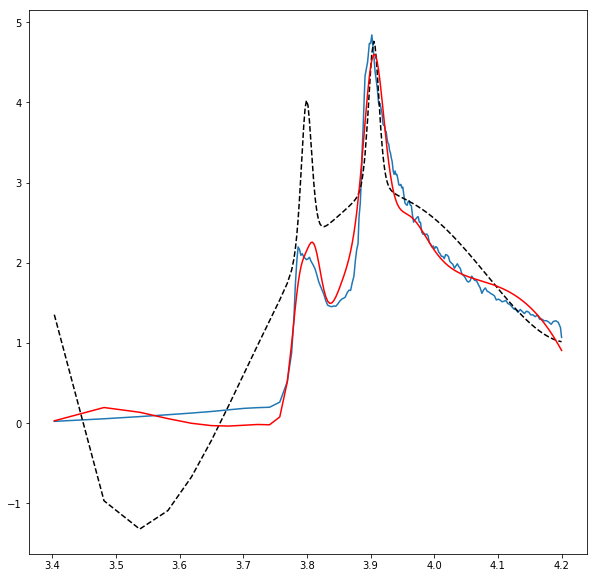

In [15]:
model = mod.fit(sigy_bot, par, x=sigx_bot)
print(model.fit_report(min_correl=0.5))

fig = plt.figure(figsize=(10, 10), facecolor='w', edgecolor='k')
plt.plot(sigx_bot, sigy_bot)
plt.plot(sigx_bot, model.init_fit, 'k--')
plt.plot(sigx_bot, model.best_fit, 'r-')